# Agrupar 

Agruparemos utilizando 2 enfoques:

- Por subtítulos
- Por videos 

Para analizar de una manera más detallada el corpus

In [1]:
from os import listdir
from os.path import isfile, join
#Para el corpus
import sys
sys.path.append('..')
from src.data import Data 
from src.utils import *
#Para calcular TF-IDF
from src.tfidf import TFIDF
#Para graficar palabras
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from tqdm import tqdm 
from collections import defaultdict
import numpy as np
from operator import itemgetter
import json
# nltk
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords #Listas de stopwords
import pickle
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

[nltk_data] Downloading package punkt to /home/karla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/karla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/karla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/karla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/karla/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/karla/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Vectores TF-IDF

### Gráficamos los vectores de TF-IDF de cada subtítulo 

In [2]:
#Cargamos el corpus limpio
videos = Data("../pkl/clean_videos.pkl")
videos.get_all_subtitles()
#Creamos el objeto tfidf
tfidf_objxO = TFIDF(videos)
# Cargamos los valores tfidf previamente calculados
tfidf_objxO.tfidf = "../pkl/tfidfxOracion.pkl" #Vectores por texto
# Obtenemos los vectores por subtítulo
tfidf_objxO.get_tfid_vectors(document=False)

100%|██████████| 9/9 [00:04<00:00,  2.16it/s]


Tomamos 2 palabras clave por subtítulo ya que la mayoría de los subtítulos no son muy largos (el más largo es de 56, pero hay muchos subtítulos de 1 palabra)

In [3]:
more = ["si", "bien", "ahora", "así", "aquí", "pues"]
stopwords_list = stopwords.words('spanish') + more

def get_2key_word(sentence):
    """
    Dada una cadena y su valor tf_idf
    Nos quedamos con las 2 primeras palabras que no sean stopwords
    para que representen al subtítulo
    """
    word = ""
    val = []
    sentence.sort(key = lambda x: x[1])
    j = 0
    if len(sentence) == 1: #Si únicamente hay una palabra
        #Hacemos padding para que el vector siempre tenga 2 entradas
        word = sentence[0][0]
        val = [sentence[0][1], 0]
    else:
        for  w, i in sentence:
            if j < 2 and w not in stopwords_list: 
                word += w + " "
                val.append(i)
                j += 1
    return word, val

In [4]:
def do_padding(vector, t):
    '''
    Agrega 0 al vector si no es del tamaño t 
    
    Args:
        vector (lst): lista de tamaño diferente
        t (int): Tamaño esperado del vector
    '''
    for _ in range(0, t - len(vector)):
        vector.append(0)

In [5]:
def get_vectors():
    '''
    Regresa un diccionario con los subtítulos y su vector tfidf
    '''
    vectors = {}
    #Iteramos sobre los canales
    for chanel in tqdm(tfidf_objxO.data.corpus):
        for video in chanel:
            #Cada texto se guarda por oraciones
            if 'subtitles' in video:
                for s in video['subtitles']:
                    sentence = list(zip(s["text"], s["tfid"]))
                    #Ordenamos los valores tf-idf
                    sentence.sort(key = lambda x: x[1])
                    #Obtenemos 1 o 2 palabras clave
                    word, val = get_2key_word(sentence)
                    #Hacemos padding para que el vector siempre tenga 2 entradas
                    do_padding(val, 2)
                    vectors[word] = val
    return vectors

In [54]:
#Función para plotear en dos dimensiones con etiquetas
def plot_words(X,ids, color='blue'):
    '''
    Gráfica las oraciones dado su vector tfid

    Args:
        X (list): coordenadas del vector aplicando PCA
        ids (list): oraciones
    '''
    r=0
    plt.scatter(X[:,0],X[:,1], marker='o', c=color)
    for label,x,y in tqdm(zip(ids, X[:,0], X[:,1])):
        plt.annotate(label, xy=(x,y), xytext=(-1,1), textcoords='offset points', ha='center', va='bottom')
        r+=1

In [7]:
mds_model = PCA(n_components=2)
vectors = get_vectors()
X_pca = mds_model.fit_transform(list(vectors.values()))

100%|██████████| 9/9 [00:11<00:00,  1.25s/it]


In [9]:
print(list(vectors.items())[100:115])

[('rescatadores vuelta ', [27.065197858734255, 2484.8587661610527]), ('metiendo éstos ', [282.80852337710803, 521.5830229150212]), ('invocas permitir ', [27.065197858734255, 1041.0958627370796]), ('revés ojos ', [299.7330332994848, 39142.70012012738]), ('raros', [318.46288535642265, 0]), ('super ello ', [1837.2216920524, 5010.494656017035]), ('increíble ', [3120.107949989873, 0]), ('alvin gustaron ', [27.065197858734255, 86.46845429347844]), ('ardillas', [79.3677011885693, 0]), ('monstruos', [465.6578681656081, 0]), ('profesionales ver ', [928.158714730899, 22988.94172971779]), ('metemos choca ', [154.5761400148225, 200.8023572942111]), ('lata ', [470.62071136727934, 0]), ('guinness libro ', [79.3677011885693, 2634.933181115102]), ('perdimos ', [206.42359959792924, 0])]


Con 10 subtítulos

10it [00:00, 3967.75it/s]


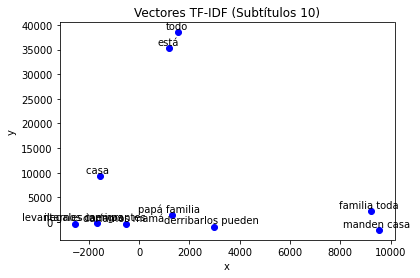

In [10]:
#Solo se gráfican algunas oraciones
plot_words(X_pca[20:30], list(vectors.keys())[20:30])
plt.title('Vectores TF-IDF (Subtítulos 10)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Con todos los subtítulos

10it [00:00, 3938.31it/s]


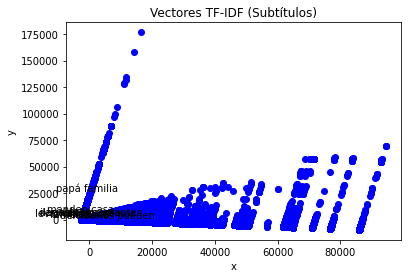

In [11]:
plot_words(X_pca, list(vectors.keys())[20:30])
plt.title('Vectores TF-IDF (Subtítulos)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

### Gráficamos los vectores de TF-IDF de cada vídeo 

In [8]:
#Cargamos el corpus limpio
videos = Data("../pkl/clean_videos.pkl")
videos.get_all_subtitles()
#Creamos el objeto tfidf
tfidf_obj = TFIDF(videos)
# Cargamos los valores tfidf previamente calculados
tfidf_obj.tfidf = "../pkl/tfidf.pkl" #Vectores por texto

100%|██████████| 9/9 [00:00<00:00, 10.40it/s]


Para generar los vectores tomaremos únicamente las 10 palabras más representativas de cada vídeo

In [9]:
def get_vectors_video():
    '''
    Regresa un diccionario con los subtítulos y su vector tfidf
    '''
    vectors = {}
    #Iteramos sobre los canales
    for id in tqdm(tfidf_obj.tfidf):
        v = sorted(tfidf_obj.tfidf[id].values(), reverse=True)[:10]
        do_padding(v,10)
        vectors[id] = v
    return vectors

In [10]:
vectors_video = get_vectors_video()
val_pca = mds_model.fit_transform(list(vectors_video.values()))

100%|██████████| 3276/3276 [00:00<00:00, 5919.38it/s]


Con 10 videos

10it [00:00, 3312.25it/s]


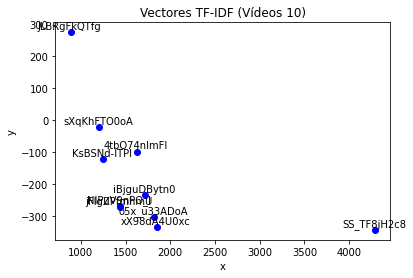

In [15]:
#Solo se gráfican algunos vídeos
plot_words(val_pca[50:60], list(tfidf_obj.tfidf.keys())[50:60])
plt.title('Vectores TF-IDF (Vídeos 10)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

Con todos los videos

1it [00:00, 2288.22it/s]


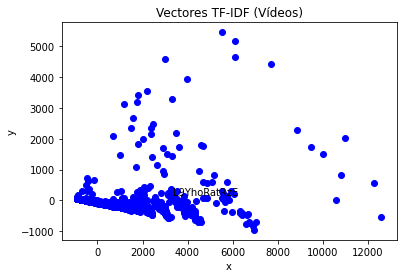

In [16]:
#Solo se gráfican vídeos
plot_words(val_pca, list(tfidf_obj.tfidf.keys())[:1])
plt.title('Vectores TF-IDF (Vídeos)')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

## K-means

In [21]:
class kMeans():
    def __init__(self, n_clusters):
        #Número de clústers
        self.n_clusters = n_clusters
        #Clústers vectores
        self.clusters = defaultdict(list)
        #Clústers con nombres
        self.named_clusters = defaultdict(list)
        #Centroides 
        self.centroids = None

    def fit(self, X, names=None):
        #Inicialización de parámetros
        C = X[np.random.choice(X[:,0].shape[0], self.n_clusters)]
        #Paro
        stop = False
        while stop == False:
            #Cálculo de distancias con respecto a c
            dists = np.array([np.linalg.norm(X-c, axis=1) for c in C])
            #Cluster más cercano
            clusts = np.argmin(dists, axis=0)
            #Clusterización de los datos
            if names != None:
                data = names
            else:
                data = [i for i in range(X.shape[0])]
            for k, v, n in zip(clusts, X, data):
                self.clusters[k].append(v)
                self.named_clusters[k].append(n)
            
            #Actualización de C
            new_c = np.array([sum(vecs)/len(vecs) for _, vecs in self.clusters.items()])

            #Criterio de paro
            if C.all() == new_c.all():
                stop = True
                self.centroids = C
            else:
                #Actualización de parámetros
                C = new_c

Probamos con los vectores TFIDF por subtítulo

In [103]:
modelxO = kMeans(10)
modelxO.fit(X_pca, list(vectors.keys()))
print(len(modelxO.named_clusters))

[[-2016.39933516  -116.10281461]
 [ -586.02806943  -524.31317327]
 [ -808.03454559  -492.7408832 ]
 [ 3031.17082943 52561.38326276]
 [ -864.59882792    96.88847046]
 [-1628.38799418   -81.55503588]
 [-2549.07220788  -307.06731131]
 [-2284.97121676  -290.52969903]
 [-1782.96591118  -369.47242692]
 [-1963.9705301    -79.01191481]]
10


In [104]:
for c, docs in modelxO.named_clusters.items():
    print(c, len(docs)) #Creo que vamos a tener que cambiar de vectores

4 61515
9 18614
6 84555
7 70516
1 97844
3 317
5 34549
0 24709
2 16532
8 28621


In [52]:
def plot_kmeans(named_clusters, clusters):
    colors = ['olive', 'orange', 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'purple']
    for c, docs in named_clusters.items():
        plot_words(np.array(clusters[c]), [], colors[c])

    plt.title('K-means')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.show()

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


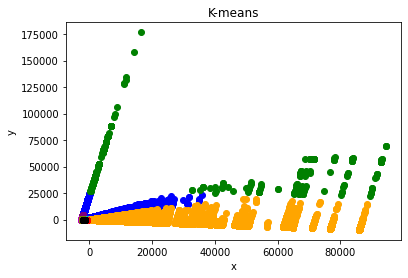

In [105]:
plot_kmeans(modelxO.named_clusters, modelxO.clusters)

In [107]:
pickle.dump([modelxO.named_clusters, modelxO.clusters], open("../pkl/sub_classKMeans.pkl", "wb"))

Probamos con los vectores TFIDF por video

In [97]:
model = kMeans(10)
model.fit(val_pca, list(tfidf_obj.tfidf.keys()))
len(model.named_clusters)

[[-374.08997827  -21.11646966]
 [ 768.99967241 -109.46702104]
 [-495.8978883    -3.38074767]
 [ 722.19665519 -201.80783469]
 [ 555.71230836 -167.43548271]
 [-829.45321428   48.58853698]
 [ 221.87534629 -101.1383587 ]
 [ 999.87250771 1479.48454996]
 [1273.6757223  -201.77476123]
 [2329.93029844 -349.46606079]]


10

In [98]:
for c, docs in model.named_clusters.items():
    print(c, len(docs)) #Creo que vamos a tener que cambiar de vectores

9 299
8 230
3 61
6 188
7 23
1 84
4 98
5 1698
2 376
0 219


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


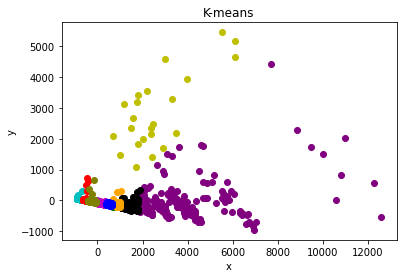

In [99]:
plot_kmeans(model.named_clusters, model.clusters)

In [108]:
pickle.dump([model.named_clusters, model.clusters], open("../pkl/video_classKMeans.pkl", "wb"))

In [13]:
with open("../pkl/video_classKMeans.pkl", "rb") as f:
    model = pickle.load(f)

named_clusters = model[0] 
clusters = model[1] 

## Clustering espectral

Toma los siguientes pasos:
- Gráfica de similitus
- Matriz de adyacencia y de grado
- Matriz Laplaciana
- Tomar los primeros eigenvectores con los eigenvalores más pequeños
- Agrupar con base a los eigenvectores utilizando k-means 

In [30]:
n = len(list(tfidf_obj.tfidf.keys()))
A = np.zeros((n,n))
k = 10

for i, di in tqdm(enumerate(val_pca)):
    neigs = {}
    for j, dj in enumerate(val_pca):
        if i != j:
            #Utilizamos la medida de similitud Gaussiana
            sim = np.exp(-np.linalg.norm(di-dj)**2)
            neigs[j] = sim
    for j, sim in sorted(neigs.items(), key=itemgetter(1), reverse=True)[:k]:
        A[i,j] = sim
        A[j,i] = sim

3276it [02:42, 20.11it/s]


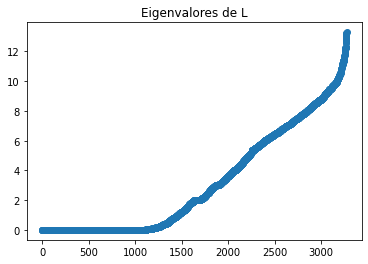

In [31]:
L = np.diag(A.sum(0)) - A
eig_vals, eig_vecs = np.linalg.eig(L)
values = sorted(zip(eig_vals.real, eig_vecs), key=itemgetter(0))
vals, vecs = zip(*values)
matrix = np.array(vecs)
plt.plot(np.array(vals), 'o')
plt.title("Eigenvalores de L")
plt.show()

0it [00:00, ?it/s]


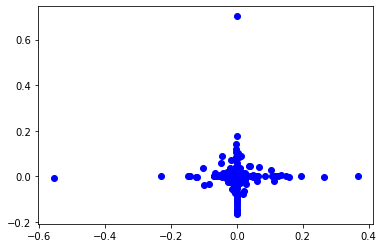

In [32]:
M_hat = matrix[1:10,:].T.real
plot_words(M_hat, [])

In [40]:
model_sp = kMeans(10)
model_sp.fit(M_hat, list(tfidf_obj.tfidf.keys()))

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


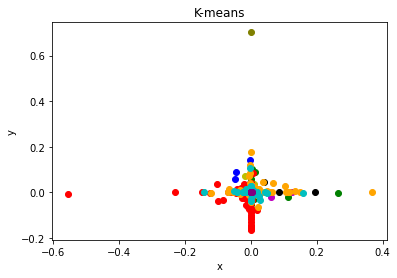

In [41]:
plot_kmeans(model_sp.named_clusters, model_sp.clusters)

In [42]:
for c, docs in model_sp.named_clusters.items():
    print(c, len(docs)) 

8 1471
7 302
4 103
0 296
3 143
2 192
6 313
1 134
5 210
9 112


In [43]:
pickle.dump([model_sp.named_clusters, model_sp.clusters], open("../pkl/video_classSpectre.pkl", "wb"))

# Por título

Por último realizaremos la agrupación por los títulos de los vídeos, para ello haremos embeddings de los títulos y utilizaremos los métodos anteriormente propuestos (k-means y espectro).


Recuperamos el id del video y su título

In [56]:
def get_tittle():
    """
    Regresa una lista con el contenido de todos los archivos de un directorio

    Args:
        path (str): ruta de la carpeta
    """
    path = "../corpus/data"
    videos = defaultdict()
    onlyfiles = [f for f in listdir(path) if isfile(join(path, f))]

    for file in onlyfiles:
        with open(path+"/"+file, 'rb') as f:
            chanel = json.loads(f.read().decode('utf-8', 'replace'))
            for v in chanel:
                videos[v["id"]] = get_tokens_clean(v["original_title"])
    return videos

In [57]:
videos_tittle = get_tittle()
print(videos_tittle["IAHQXsLS3P8"])

['receta', 'de', 'pastel', 'con', 'almendras', 'crema', 'y', 'chocolate', 'tan', 'suave', 'y', 'delicioso', 'que', 'te', 'sorprenderá']


Para los embeddings utilizaremos Doc2Vec que es words2vec pero para parrafos, documentos, en este caso títulos (oraciones) 

In [58]:
# Convertimos los tokens de cada título en el formato requerido por gensim 
tagged_data = [TaggedDocument(d[1], [i]) for i, d in enumerate(videos_tittle.items())]
tagged_data[:5]

[TaggedDocument(words=['ataque', 'vampiro', 'a', 'medianoche', 'vampire', 'in', 'the', 'garden', 'clip', 'netflix', 'aime'], tags=[0]),
 TaggedDocument(words=['love', 'death', 'robots', 'volumen', '3', 'tráiler', 'oficial', 'netflix', 'anime'], tags=[1]),
 TaggedDocument(words=['la', 'encantadora', 'srta', 'cáliz', 'el', 'show', 'de', 'cuphead', 'clip', 'netflix', 'anime'], tags=[2]),
 TaggedDocument(words=['la', 'temporada', '2', 'de', 'titanes', 'del', 'pacífico', 'tierra', 'de', 'nadie', 'ya', 'disponible', 'netflix', 'anime'], tags=[3]),
 TaggedDocument(words=['tiger', 'bunny', '2', 'watch', 'party', 'ep', '4', 'con', 'los', 'actores', 'de', 'voz', 'netflix', 'anime'], tags=[4])]

Entrenamos

In [59]:
## Train doc2vec model
model = Doc2Vec(tagged_data, vector_size=20, window=2, min_count=1, workers=4, epochs = 100)
model.train(tagged_data, total_examples=model.corpus_count, epochs=model.epochs)
model.save("models/test_doc2vec.model")

In [61]:
## Load saved doc2vec model
model= Doc2Vec.load("models/test_doc2vec.model")

In [62]:
print(len(model.dv), len(tagged_data))

3328 3328


In [63]:
ids = list(videos_tittle.keys())
mds_model = PCA(n_components=2)
vectos = np.array([model.dv[v] for v in range(len(model.dv))])
d2v_pca = mds_model.fit_transform(vectors)

In [64]:
model_d2v = kMeans(10)
model_d2v.fit(d2v_pca, ids)
len(model_d2v.named_clusters)

10

In [65]:
for c, docs in model_d2v.named_clusters.items():
    print(c, len(docs))

5 168
2 303
3 572
1 225
9 322
7 333
8 327
0 326
4 421
6 331


0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


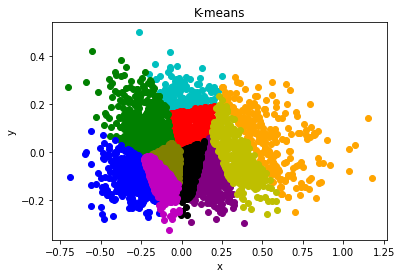

In [66]:
plot_kmeans(model_d2v.named_clusters, model_d2v.clusters)

In [68]:
pickle.dump([model_d2v.named_clusters, model_d2v.clusters], open("../pkl/video_classD2V.pkl", "wb"))

In [70]:
model_d2v.named_clusters

defaultdict(list,
            {5: ['_DZF9EqExZM',
              'A3wzAdJjOSA',
              'Fk-_2Nriebg',
              'bQrsb576bXw',
              'KvxUTYD9tjs',
              'm0yLsM6JxFU',
              '2d2fq0Z3xNk',
              'bQZgO_ZA5jU',
              'AbzXxtesmNg',
              '7WA0E_i4KVs',
              'tvqmSLbgE9M',
              '2pEhJhckEQU',
              'rQpkIzAUzmw',
              '352_T-yIonI',
              'Y3aOOsO2QuA',
              '8ADXXUuENDc',
              'YpXjE9gl4HE',
              'N-n2w1wdz40',
              'ozP5e_Ro_tE',
              'BU--ttm4nYs',
              'sxNo7eLhf-I',
              'BQdF9h-u6j8',
              'tA7Eej8pTxM',
              'mMxYu5j9ZZ4',
              'JfiUDfu03HI',
              'Zr-vW3th2Ts',
              'daHMPoT5Nos',
              'vB8FrSJyhCo',
              'QQBbsWjYYUI',
              'tGDAp5iRuTQ',
              'Ap99cFhPb8E',
              'ZAKsU-U5SE8',
              'NEjNsAiXUws',
              'nqAxRJh